# Création d'un scatter plot interactif

In [2]:
import sys

rootDir = "//ifb/data/mydatalocal"
projectDir = rootDir + "/VDBscratch"
libDir = projectDir + "/lib"
dataDir= "/ifb/data/public/teachdata/m2binf_ucbl/data" 

sys.path.append(libDir)

In [3]:
import pandas, uniprot, go
import numpy as np
from stat_utils import computeORA_BKG
# We use notebook backend to have interactivity support
%matplotlib notebook 

import matplotlib.pyplot as plt

#### Visualisation des abondances et Pathway pour chaque protéine
Nous allons représenter la relation entre l'abondance des protéines (**Log2 Corrected Abundance Ratio**)  et la précision de la mesure (**LOG10 Adj.P-val**). 
###### Creation du scatter plot
[matplotlib.axes.Axes.scatter()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.scatter.html) permet d'intialiser le graphique.
###### Modification continue du scatter plot
Mais cette fonction retourne aussi un objet [PathCollection](https://matplotlib.org/3.1.1/api/collections_api.html) qui permet de modifier à posteriori le rendu des points du scatter plot.
###### Interactivité
L'affichage d'une figure via la méthode `fig.canvas.mpl_connect('EVENT_NAME', callbackFunction)` permet d'associer à [un évenement sur la figure](https://matplotlib.org/3.1.1/users/event_handling.html) l'execution du fonction (*callbackFunction*)

###### Illustration ci-dessous
Observer le comportement interactif du graphique. Commenter alternativement les deux décalarations `cid = fig.canvas.mpl_connect()`.

In [19]:
type("a")

str

<IPython.core.display.Javascript object>


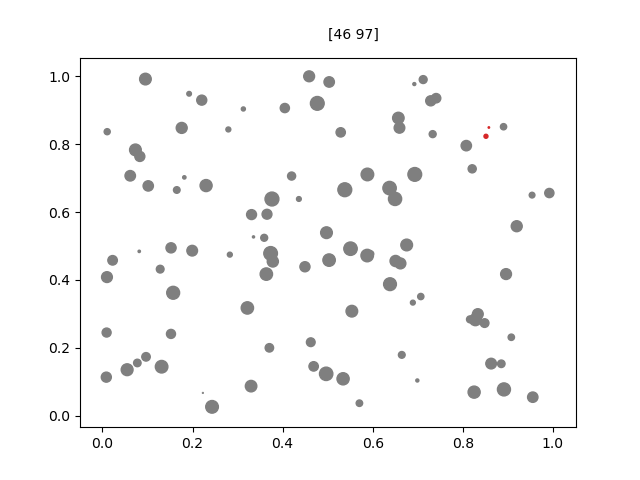

In [23]:
x, y, c, s = np.random.rand(4, 100)

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)
    col.set_sizes( np.random.rand(100) * 100 )
    
def onpick(event):
    ind = event.ind #numpy.ndarray
    tx = str(ind)
    text.set_text(tx)
    col.set_sizes( np.random.rand(100) * 100 )
   # col.set_color(  )
    _c = np.full(100, 'tab:gray')
    for i in ind:
        _c[i] = 'tab:red'
    col.set_color(_c)
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
col = ax1.scatter(x, y, 100*s, c, picker=True)
text = ax1.text(0.5,1.1, "", va="bottom", ha="left")

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onpick)

### 3a Volcano plot interactif

##### Read-in data
* Array of protein names
* Array of abundace ratios
* Array of experimental pValue

In [14]:
import pandas
df=pandas.read_csv(projectDir + "/TCL_wt1.tsv", delimiter ="\t")

dfClean = df[ (df['Log2 Corrected Abundance Ratio'] != '#VALEUR!') & (df['LOG10 Adj.P-val'] != '#VALEUR!')]
dfClean = dfClean.copy()
dfClean.loc[:,'Log2 Corrected Abundance Ratio'] = dfClean.loc[:,'Log2 Corrected Abundance Ratio'].astype(float)
dfClean.loc[:,'LOG10 Adj.P-val'] = dfClean.loc[:,'LOG10 Adj.P-val'].astype(float)


saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
allList = dfClean[ : ]['Accession'].tolist()
pvalue = dfClean[ : ]['LOG10 Adj.P-val'].tolist()
abundance = dfClean[ : ]['Log2 Corrected Abundance Ratio'].tolist()

##### Dessiner un volcano plot qui affichera le nom de la protéine clickée

In [45]:
### Cellule Exercice
x,y,label = (abundance, pvalue, allList)
print(f"{x[:10]}\n{y[:10]}\n{label[:10]}")

[-3.721334942, -3.429568818, -3.284695189, -3.204276506, -3.009460329, -2.979403095, -2.858216749, -2.733825887, -2.6485786, -2.625119627]
[4.260067469, 3.45462743, 4.571899347, 1.699767669, 1.434786589, 2.887197633, 6.154103778, 2.878506676, 0.328873724, 0.277155457]
['P75936', 'P76231', 'P0A8S9', 'P05706', 'P29744', 'P0A9A2', 'P75937', 'P43533', 'P0ABR1', 'P26608']


### Visualisation des protéines et pathways
#### Préambule 
1. Read-in data. **Attention** : Vous devez avoir collecté la liste des protéines de l'experience 
2. Réaliser *OverRepresentationAnalysis* sur le namespace GO de votre choix
    * exemple ci-dessous avec *biological process*

In [59]:
import json
a={"23": 10, "AA": 33}

with open('result.json', 'w') as fp:
    json.dump(a, fp)

In [58]:
list(set(xpGoTree_BP.getMembersByName("siderophore transport")))

['P13036',
 'P02930',
 'P76115',
 'P05825',
 'P75780',
 'P06971',
 'P0AEL6',
 'P23878']

In [24]:
if not allList:
    raise ValueError('please read protein list from TSV')

GO_namespace = "biological process" # biological_process, molecular function, cellular component)
uniprotCollection = uniprot.UniprotCollection(dataDir +"/dataset")
K12 = uniprot.UniprotCollection(dataDir + "/K12_proteome/")
print("Loading ontology")
go.setOntology(dataDir + "/go.owl")


print(f"Extracting {GO_namespace} ontology")
xpGoTree_BP = go.AnnotationTree(GO_namespace, collapse=True)
xpGoTree_BP.extract(allList, uniprotCollection)


fullEcoliGoTree_BP = go.AnnotationTree(GO_namespace, collapse=True)
fullEcoliGoTree_BP.extract(K12.list, K12)


class Rankings():
    def __init__(self, oraResults, proteinList, title="Pathway ORA"):
        self.title = title
        self.ranks = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(proteinList) ), len(proteinList) ) for d in sorted(oraResults, key=lambda x:x[0]) ]
    def _repr_html_(self):
        t_head = f"<h3>{self.title}</h3><table><thead><th>p-value</th><th>Pathway name</th><th>n</th></thead><tbody>"
        t_foot = '</tbody></table>'
        t_body = '</tr><tr>'.join([ '<td>' + '</td><td>'.join([ str(v) for v in pathwayScore ][:-1]) + '</td>' for pathwayScore in self.ranks ])
        t_body = '<tr>' + t_body + '</tr>'
        return t_head + t_body + t_foot
    
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
oraFisher, oraCDF = computeORA_BKG(xpGoTree_BP, saList, fullEcoliGoTree_BP)
rankingsObj = Rankings(oraFisher,saList, title=GO_namespace)
rankingsObj

Loading ontology
Loaded
Extracting biological process ontology
Applying true path collapsing
2194 leaves, 3482 nodes, 1474 proteins
Applying true path collapsing
2728 leaves, 6650 nodes, 3128 proteins
Evaluated 298 / 2194 Pathways, based on 44 proteins


3.0740143676824805e-06,siderophore transport,5
1.4333376891745052e-05,iron coordination entity transport,5
2.9305999920744405e-05,protein insertion into membrane,4
3.1801614970675325e-05,membrane organization,5
5.221318723734416e-05,Gram-negative-bacterium-type cell outer membrane assembly,4
5.221318723734416e-05,membrane assembly,4
6.758963970377286e-05,establishment of protein localization to membrane,4
0.0001285368129330478,iron ion transport,5
0.00019634523788932085,ion transport,13
0.00023663274449265561,protein localization to membrane,4
0.0002536535809632806,macromolecule localization,8


In [63]:
rankingsObj.ranks[0]

(3.0740143676824805e-06, 'siderophore transport', 5, 44)

In [66]:
import json
    
res = {}
n = 10
for pValue, pathwayName, nb, total in rankingsObj.ranks[:n]: 
    res[ pathwayName ] = list( set(xpGoTree_BP.getMembersByName(pathwayName) ))

with open('TP3_dict.json', 'w') as fp:
    json.dump(res, fp)

res

{'siderophore transport': ['P13036',
  'P02930',
  'P76115',
  'P05825',
  'P75780',
  'P06971',
  'P0AEL6',
  'P23878'],
 'iron coordination entity transport': ['P13036',
  'P69490',
  'P15028',
  'P02930',
  'P76115',
  'P05825',
  'P75780',
  'P06971',
  'P0AEL6',
  'P23878'],
 'protein insertion into membrane': ['P0AEU7',
  'P0AGA2',
  'P0AC02',
  'P0A937',
  'P0A940',
  'P25714',
  'P0A903',
  'P0AG99',
  'P77774'],
 'membrane organization': ['P0AGA2',
  'P0ABZ6',
  'P76445',
  'P66948',
  'P0ADV1',
  'P76506',
  'P43671',
  'P0A903',
  'P0AEU7',
  'P0ADV9',
  'P0AC02',
  'P0A937',
  'P31554',
  'P0A940',
  'P25714',
  'P0AG99',
  'P0ADV7',
  'P60752',
  'P0ADC1',
  'P77774'],
 'Gram-negative-bacterium-type cell outer membrane assembly': ['P66948',
  'P0AEU7',
  'P0ADV1',
  'P0ADV9',
  'P0AC02',
  'P0A937',
  'P31554',
  'P0A940',
  'P0A903',
  'P0ABZ6',
  'P0ADC1',
  'P77774',
  'P76445'],
 'membrane assembly': ['P66948',
  'P0AEU7',
  'P0ADV1',
  'P0ADV9',
  'P0AC02',
  'P0A937'


###### Pour chaque Terme GO que vous souhaitez representer dans le volcano plot
###### Lister toutes les protéines (feuilles) de ce terme (sous-arbre)

```python
list (set (xpGoTree_BP.getByName(goTermName).getMembers() )
```

### Puis, au choix
* Colorier les protéines des n Pathway les plus représentés dans le namespace GO de votre choix (biological_process, molecular function, cellular component): **utiliser des palettes de couleurs catégorielles**. Priorités sera donné au pathway avec le meilleur score ORA.
* Dessiner un volcano plot qui coloriera d'une même couleur les protéines appartenant au pathway GO de la protéine clickée
* Dessiner un volcano plot qui fera disparaitre les protéines n'appartenant pas au même pathway GO de la protéine clickée

<IPython.core.display.Javascript object>


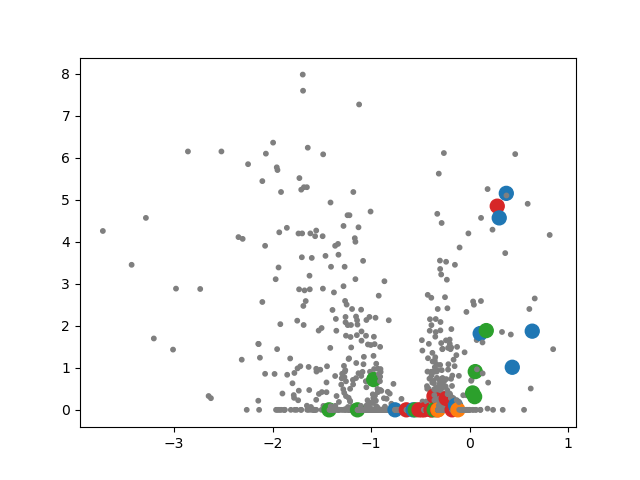

In [67]:
### Cellule Exercice
rules = []
palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, goTerm in enumerate(rankingsObj.ranks[:5]):
    #print(f"{goTerm[1]} ({goTerm[0]}): { list(set(xpGoTree_BP.getByName(goTerm[1]).getMembers()))}")
    rules.append( (goTerm[1], goTerm[0], 
                   list(set(xpGoTree_BP.getByName(goTerm[1]).getMembers())), palette[i] ) )
rules

def getColor(name):
    for rule in rules:
        if name in rule[2]:
            return rule[3]
    return 'tab:gray'

def getSize(name, _min=10, _max=100):
    for rule in rules:
        if name in rule[2]:
            return _max
    return _min

c = [ getColor(n) for n in label ]
s = [ getSize(n) for n in label ]
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
col = ax1.scatter(x, y, s, c)
#text = ax1.text(-1.5,9, "", va="bottom", ha="left")

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
#cid = fig.canvas.mpl_connect('pick_event', onpick)